In [140]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [328]:
file = 'AAPL.csv'
#csv to read from
def read(file):
    df = pd.read_csv(file)
    df = pd.read_csv(file, index_col='Date')
    df.index = pd.to_datetime(df.index)
    df = df["2019":"2022-01"]
    df = df.iloc[:, 3:-2]  # Trim off the last 5 columns
    return df
rawData = read(file)
# Convert the NumPy array to a DataFram
rawData = pd.DataFrame(rawData)
# plot df

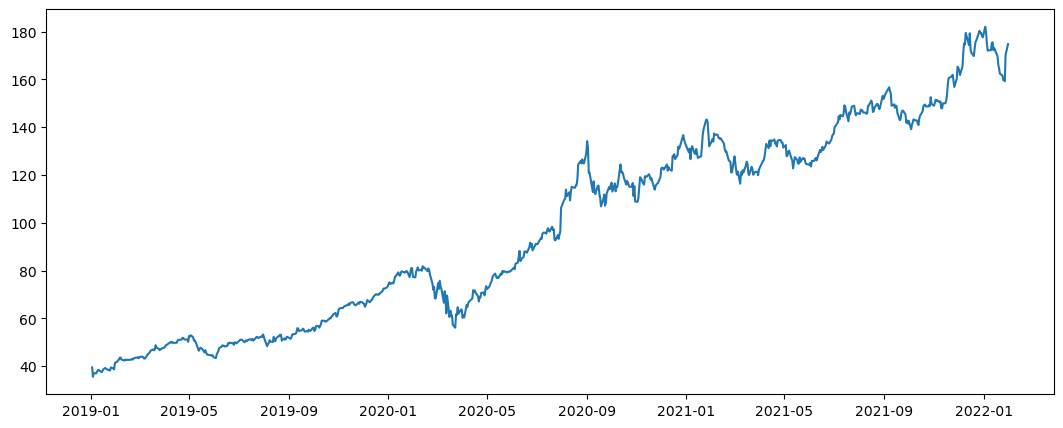

In [329]:
plt.figure(figsize=(13,5))
plt.plot(rawData, label='test')

In [330]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
train = sc.fit_transform(rawData)
seq_length = 4
x, y = sliding_windows(train, seq_length)

train_size = int(len(y) * 0.7)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [331]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [343]:
num_epochs = 1250
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()


# Calculate the percentage error for the test set
test_outputs = lstm(testX)
test_loss = criterion(test_outputs, testY)
test_percentage_error = (torch.sqrt(test_loss) / torch.mean(testY)) * 100

print("Test percentage error:", test_percentage_error.item(), "%")


Test percentage error: 5.622750282287598 %


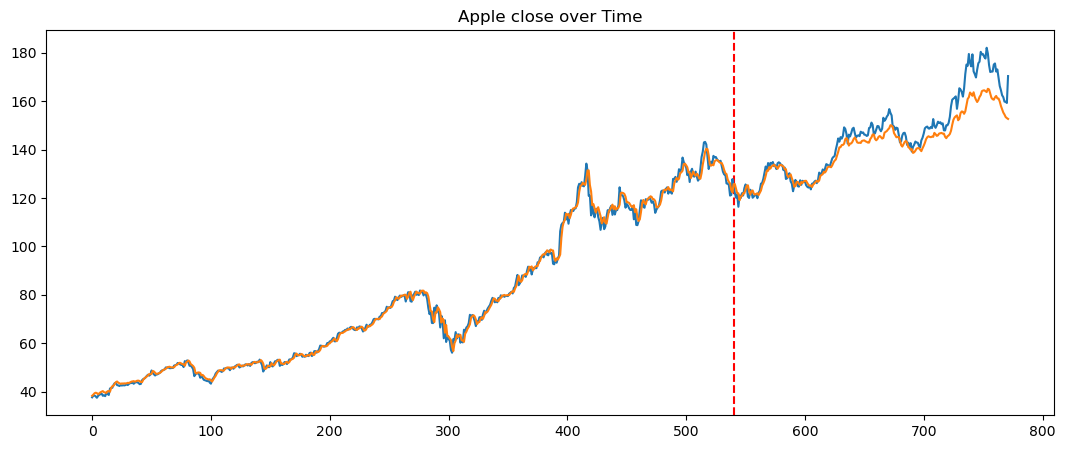

In [344]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize=(13,5))
plt.axvline(x=train_size, c='r', linestyle='--')
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.title('Apple close over Time')
plt.show()

In [345]:
dataPredict

,0
0,2565.505859
1,2586.837402
2,2598.595703
3,2609.022461
4,2610.575928
...,...
767,4339.971680
768,4332.664551
769,4299.993652
770,4287.860840


In [346]:
dataPredict = pd.DataFrame(data_predict)
rawData2 = rawData.iloc[5:]
dataPredict_with_index = dataPredict.set_index(rawData2.index)
dataPredict_with_index2 = dataPredict_with_index.iloc[542:]
dataPredict_with_index2.to_csv('abble2.csv')
output = pd.concat([rawData2, dataPredict_with_index], axis=1)
output.rename(columns={0: 'Predicted Close'}, inplace=True)
output.to_csv('outputabble.csv')

In [349]:
dataPredict_with_index2

,0
Date,
2021-03-05,123.881592
2021-03-08,121.933296
2021-03-09,121.908348
2021-03-10,119.040123
2021-03-11,120.596252
...,...
2022-01-25,155.274887
2022-01-26,154.447952
2022-01-27,153.409668


In [348]:
output

,Close,Predicted Close
Date,,
2021-03-05,121.419998,123.881592
2021-03-08,116.360001,121.933296
2021-03-09,121.089996,121.908348
2021-03-10,119.980003,119.040123
2021-03-11,121.959999,120.596252
...,...,...
2022-01-25,159.779999,155.274887
2022-01-26,159.690002,154.447952
2022-01-27,159.220001,153.409668


In [206]:
maxClosePredict = output['Predicted Close'].max()

In [207]:
minClosePredict = output['Predicted Close'].min()

In [208]:
maxDate = output['Predicted Close'].idxmax()
minDate = output['Predicted Close'].idxmin()

In [209]:
listMinMax = [(maxClosePredict, maxDate), (minClosePredict, minDate)]

In [210]:
minmaxFrame = pd.DataFrame(listMinMax)

In [211]:
minmaxFrame.to_csv('minmaxTesla.csv')

In [212]:
minmaxFrame

,0,1
0,1039.713135,2021-11-09
1,593.587219,2021-05-21
